# Modélisation SIFT

## Import des librairies

In [75]:
import pandas as pd
from matplotlib.image import imread
import matplotlib.pyplot as plt
import os
import time
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

In [76]:
sns.set_context('talk')

In [77]:
df = pd.read_csv('Flipkart/flipkart_com-ecommerce_sample_1050.csv', index_col='uniq_id')

## Création des labels

In [78]:
df['product_category_tree_clean'] = df['product_category_tree'].str.replace('[', '', regex=True).replace('"', '', regex=True).str.split('>>')

df['product_category_first_elem'] = df['product_category_tree_clean'] .apply(lambda x : x[0])


## Preprocessing

In [80]:
path = os.getcwd() + "/Flipkart/Images/"

In [81]:
list_photos = list(df.image)

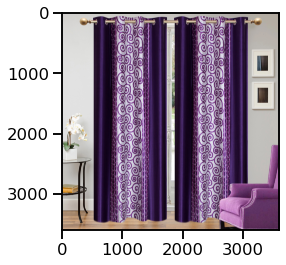

In [82]:
# Aperçu de la première image

test = path + list_photos[0]
image = imread(test)
plt.imshow(image)

In [83]:
import cv2
sift = cv2.xfeatures2d.SIFT_create()

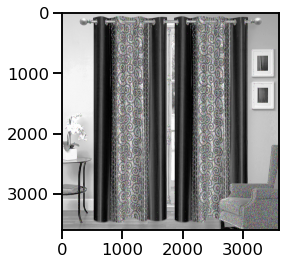

Descripteurs :  (98201, 128)

[[  0.   0.   0. ...   0.   0.   0.]
 [  7.   0.   0. ...   3.   0.   7.]
 [ 12.   6.   3. ...   4.   0.   0.]
 ...
 [113.  43.  54. ...   0.   0.   0.]
 [ 33.  14.   3. ...  16.   5.   3.]
 [ 57.  32. 118. ...   0.   0.   0.]]


In [84]:
# Tranformation en nuances de gris et égalisation des couleurs sur une image

image = cv2.imread(path+list_photos[0],0) # convert in gray
image = cv2.equalizeHist(image)   # equalize image histogram
kp, des = sift.detectAndCompute(image, None)
img=cv2.drawKeypoints(image,kp,image)
plt.imshow(img)
plt.show()
print("Descripteurs : ", des.shape)
print()
print(des)

In [85]:
# Preprocessing sur l’ensemble du jeu de données
# Identification des points clés 

sift_keypoints = []
temps1=time.time()
sift = cv2.xfeatures2d.SIFT_create(500)

for image_num in range(len(list_photos)) :
    if image_num%100 == 0 : print(image_num)
    image = cv2.imread(path+list_photos[image_num],0) 
    # image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    res = cv2.equalizeHist(image)   # equalize image histogram
    kp, des = sift.detectAndCompute(res, None)
    sift_keypoints.append(des)

0
100
200
300
400
500
600
700
800
900
1000


## Création des descripteurs

In [86]:
# Descripteurs par image
sift_keypoints_by_img = np.asarray(sift_keypoints, dtype=object)
# Ensemble des descripteurs 
sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

duration1=time.time()-temps1
print("temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")


Nombre de descripteurs :  (517312, 128)
temps de traitement SIFT descriptor :           338.83 secondes


## Création des clusters de descripteurs

In [92]:
from sklearn import cluster, metrics

# Détermination du nombre de clusters 
temps1=time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  719
Création de 719 clusters de descripteurs ...
temps de traitement kmeans :            39.32 secondes


## Création des features des images

In [93]:
# Creation des histogrammes (features)
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Création d’une matrice d’histogrammes
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :             2.65 secondes


In [96]:
# Réduction de la dimension avec une PCA (étape préléminaire à T-SNE)

from sklearn import manifold, decomposition

print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 719)
Dimensions dataset après réduction PCA :  (1050, 505)


In [99]:
data = pd.DataFrame()
data["image_path"] = list_photos

In [100]:
# Réduction de la dimension pour visualisation

from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = df['product_category_first_elem'].reset_index().drop('uniq_id', axis=1)['product_category_first_elem']
print(df_tsne.shape)

(1050, 3)


In [101]:
df_tsne.head()

,tsne1,tsne2,class
0,-6.216617,20.431480,Home Furnishing
1,-5.301175,24.533752,Baby Care
2,11.666744,17.576942,Baby Care
3,-11.612099,27.781807,Home Furnishing
4,-4.152365,17.838322,Home Furnishing
...,...,...,...
1045,-8.087306,-2.108663,Baby Care
1046,17.249063,13.446512,Baby Care
1047,-12.549087,-4.505622,Baby Care
1048,32.491165,-16.190763,Baby Care


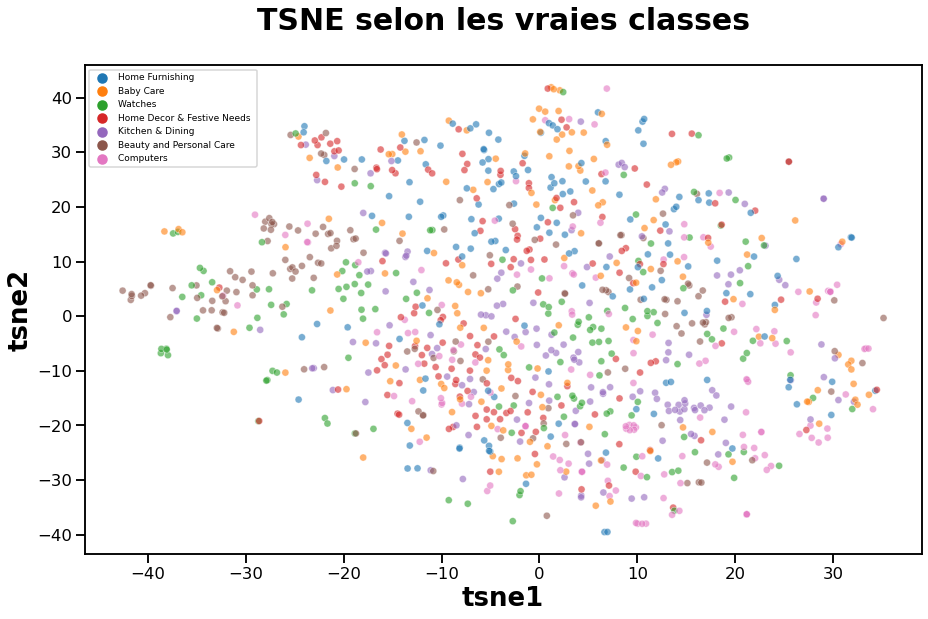

In [106]:
# Visualisation des vrais classes

sns.set_context('talk')
plt.figure(figsize=(15,9))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne,
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 9}) 

plt.show()

In [103]:
# Clustering

from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)


(1050, 4)


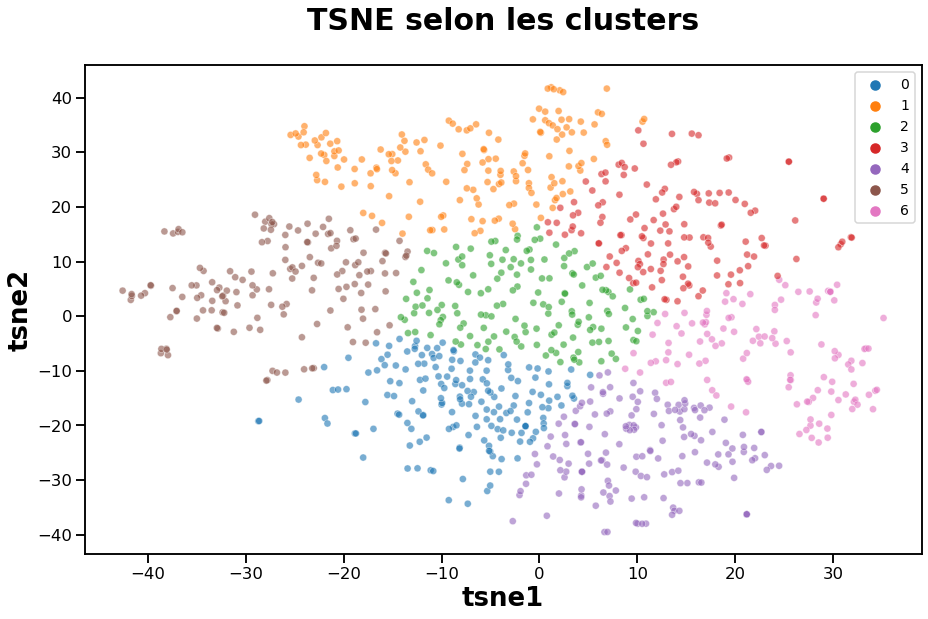

ARI :  0.06075171075185712


In [104]:
# Visualisation des vrais clusters

plt.figure(figsize=(15,9))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

# Calcul de l’ARI

labels = df['product_category_first_elem']
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))